# Setup

In [37]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import HTML,clear_output
from importlib import reload
import time

import itertools
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
import plotly.graph_objects as go

from importData import import_all,generate_diffuse_tether_trajectories
import displayData
import trajAnalysis
import bayesianTools
from model_utils import GenerationMode
import model
from utils import notebook_setup_widgets,accuracy_of_hidden_paths
import tests

from scipy.stats import loguniform
from config import OUTPUTS_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
df = pd.read_feather("df_results.fea")
df["regime"]=(df["regime"].values+1).astype(str)
df["delta_logL"] = (df["logL_viterbi"]-df["logL_true"])
df["sign_delta_logL"] = np.sign(df["delta_logL"]).astype(int)
df["N_steps"] = df["T"]/df["dt"]

<IPython.core.display.Javascript object>


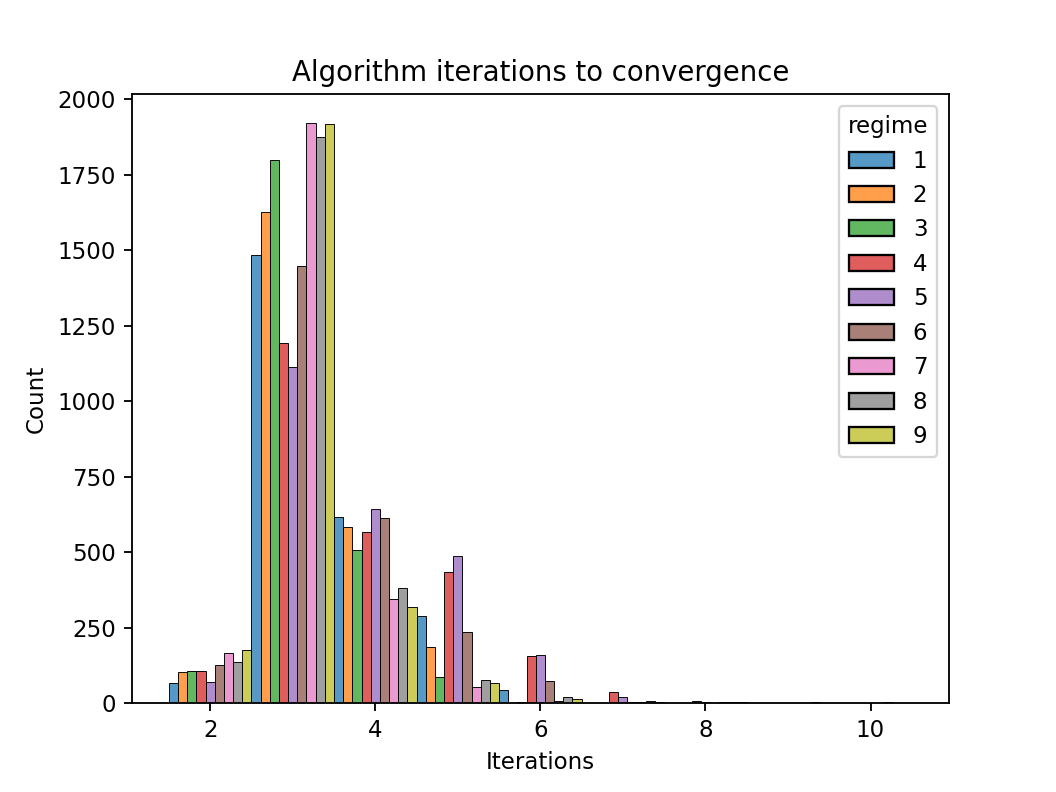

Text(0.5, 0, 'Iterations')

In [50]:
fig,ax=plt.subplots()
sns.histplot(data=df,x="N_iter",hue="regime",common_norm=False,discrete=True,multiple="dodge")
ax.set_title("Algorithm iterations to convergence")
ax.set_xlabel("Iterations")

<IPython.core.display.Javascript object>


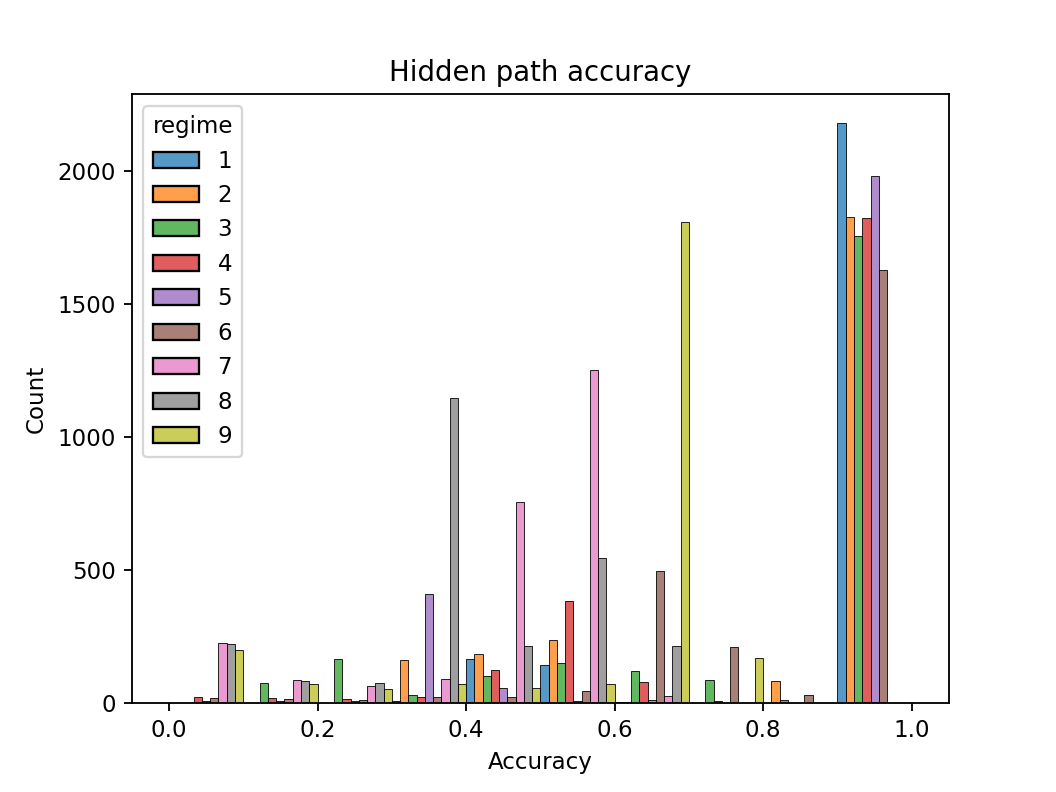

Text(0.5, 0, 'Accuracy')

In [52]:
fig,ax=plt.subplots()
sns.histplot(data=df,x="acc",hue="regime",common_norm=False,bins=10,multiple="dodge")
ax.set_title("Hidden path accuracy")
ax.set_xlabel("Accuracy")

In [67]:
df.groupby("regime").acc.describe().round(3)

,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
1,2500.0,0.934,0.170,0.373,0.998,0.999,1.000,1.000
2,2500.0,0.869,0.227,0.304,0.860,0.999,1.000,1.000
3,2500.0,0.837,0.270,0.120,0.666,0.999,1.000,1.000
4,2500.0,0.815,0.204,0.011,0.623,0.930,0.934,0.943
5,2500.0,0.832,0.245,0.018,0.947,0.954,0.958,0.968
6,2500.0,0.840,0.166,0.007,0.698,0.940,0.947,0.958
7,2500.0,0.444,0.158,0.000,0.483,0.500,0.520,0.624
8,2500.0,0.383,0.165,0.000,0.322,0.350,0.536,0.672
9,2500.0,0.578,0.203,0.000,0.637,0.660,0.679,0.743


<IPython.core.display.Javascript object>


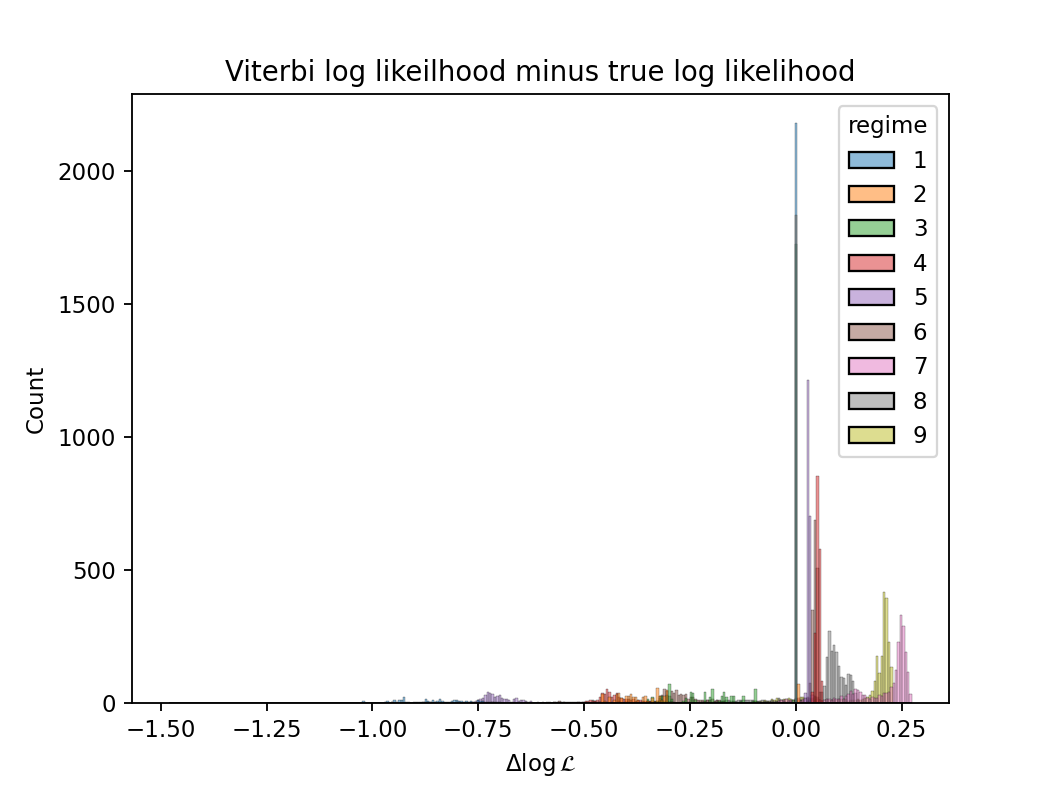

In [100]:
fig,ax=plt.subplots()
sns.histplot(data=df,x="delta_logL",hue="regime",common_norm=False)
ax.set_title("Viterbi log likeilhood minus true log likelihood")
_=ax.set_xlabel(r'$\Delta\log{\mathcal{L}}$')

In [70]:
df.groupby("regime").delta_logL.describe().round(6)

,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
1,2500.0,-0.108237,0.285581,-1.021116,0.000501,0.000831,0.001543,0.002579
2,2500.0,-0.088132,0.160906,-0.475880,0.000076,0.000411,0.000597,0.003324
3,2500.0,-0.067241,0.110610,-0.359930,-0.145851,0.000162,0.000402,0.001311
4,2500.0,-0.092644,0.249163,-1.034485,-0.349413,0.050367,0.054166,0.063232
5,2500.0,-0.130045,0.321090,-1.480720,0.026729,0.029500,0.031990,0.037645
6,2500.0,-0.081643,0.185925,-0.752611,-0.261118,0.042194,0.047447,0.053359
7,2500.0,0.190128,0.091020,-0.384905,0.144212,0.237820,0.251722,0.274049
8,2500.0,0.057149,0.091239,-0.753763,0.064973,0.085374,0.104226,0.153436
9,2500.0,0.158176,0.095137,-0.921021,0.146375,0.204478,0.213820,0.228656


<IPython.core.display.Javascript object>


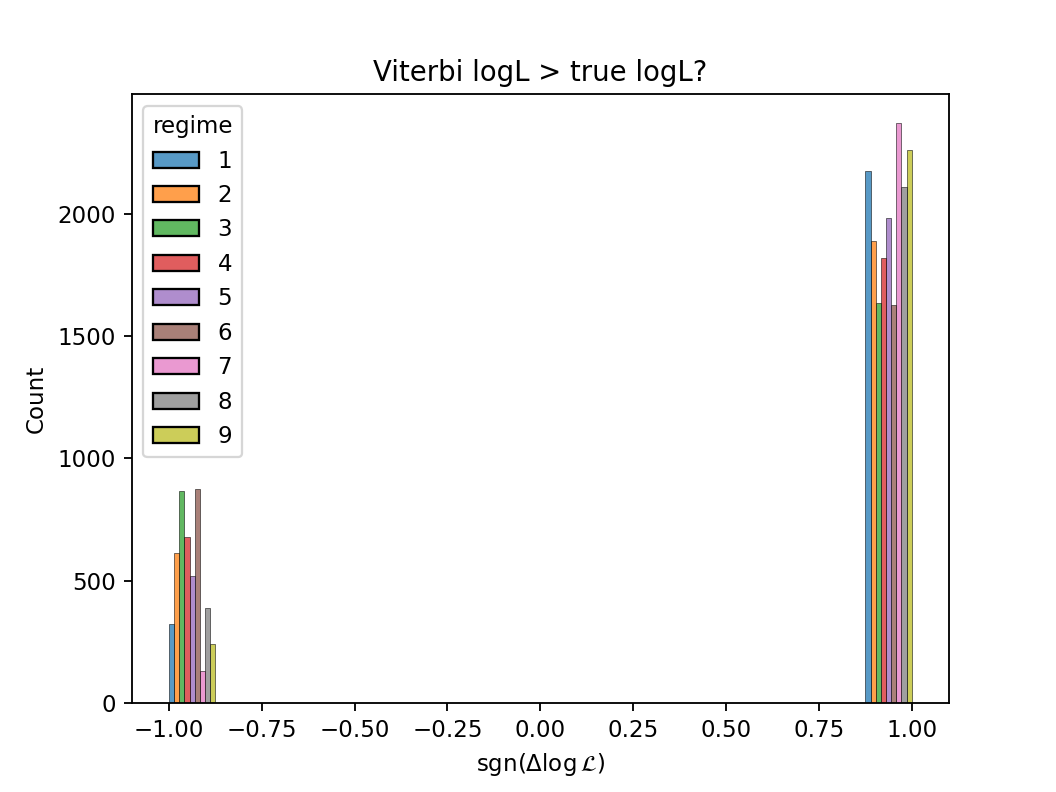

In [56]:
fig,ax=plt.subplots()
sns.histplot(data=df,x="sign_delta_logL",hue="regime",common_norm=False,multiple="dodge")
ax.set_title("Viterbi logL > true logL?")
_=ax.set_xlabel(r'${\rm sgn}(\Delta\log{\mathcal{L}})$')

In [43]:
df[df["delta_logL"]<0]

,n_init_condition,acc,N_iter,param0_i_ratio,param1_i_ratio,param2_i_ratio,param3_i_ratio,param0_f_ratio,param1_f_ratio,param2_f_ratio,...,param2_true,param3_true,logL_true,dt,T,n_realization,regime,delta_logL,sign_delta_logL,N_steps
6,6,0.5482,3,1.643384,5.958161,30.281918,0.020812,0.433519,0.029398,0.629083,...,1.0,1,-4.504096,10,100000,0,1,-0.772866,-1,10000.0
9,9,0.5461,3,0.166290,9.013292,0.098916,0.049243,3.097500,0.027187,0.596414,...,1.0,1,-4.504096,10,100000,0,1,-0.800834,-1,10000.0
13,13,0.5442,4,0.026820,1.583847,0.070270,0.021296,4.152500,0.013750,0.593361,...,1.0,1,-4.504096,10,100000,0,1,-0.803168,-1,10000.0
22,22,0.5438,2,0.079063,0.084238,0.639687,0.020059,1.779643,0.005893,0.593386,...,1.0,1,-4.504096,10,100000,0,1,-0.805405,-1,10000.0
27,27,0.5449,2,0.138615,0.088186,0.800236,0.030163,1.204024,0.015366,0.598817,...,1.0,1,-4.504096,10,100000,0,1,-0.798917,-1,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22447,47,0.2049,3,0.022694,3.638311,0.626869,1.927972,0.249346,3.239252,1.536289,...,1.0,1,-3.620426,1,10000,24,9,-0.027485,-1,10000.0
22453,53,0.0074,3,0.105266,13.797044,0.269734,9.331942,0.101724,34.275862,1.741352,...,1.0,1,-3.620426,1,10000,24,9,-0.028075,-1,10000.0
22461,61,0.0271,3,0.151008,13.504874,12.039680,25.709879,0.117391,12.186335,1.986704,...,1.0,1,-3.620426,1,10000,24,9,-0.067827,-1,10000.0
22465,65,0.0022,3,0.044479,0.819981,0.138532,25.100541,0.100000,83.125000,2.067719,...,1.0,1,-3.620426,1,10000,24,9,-0.105050,-1,10000.0


<IPython.core.display.Javascript object>


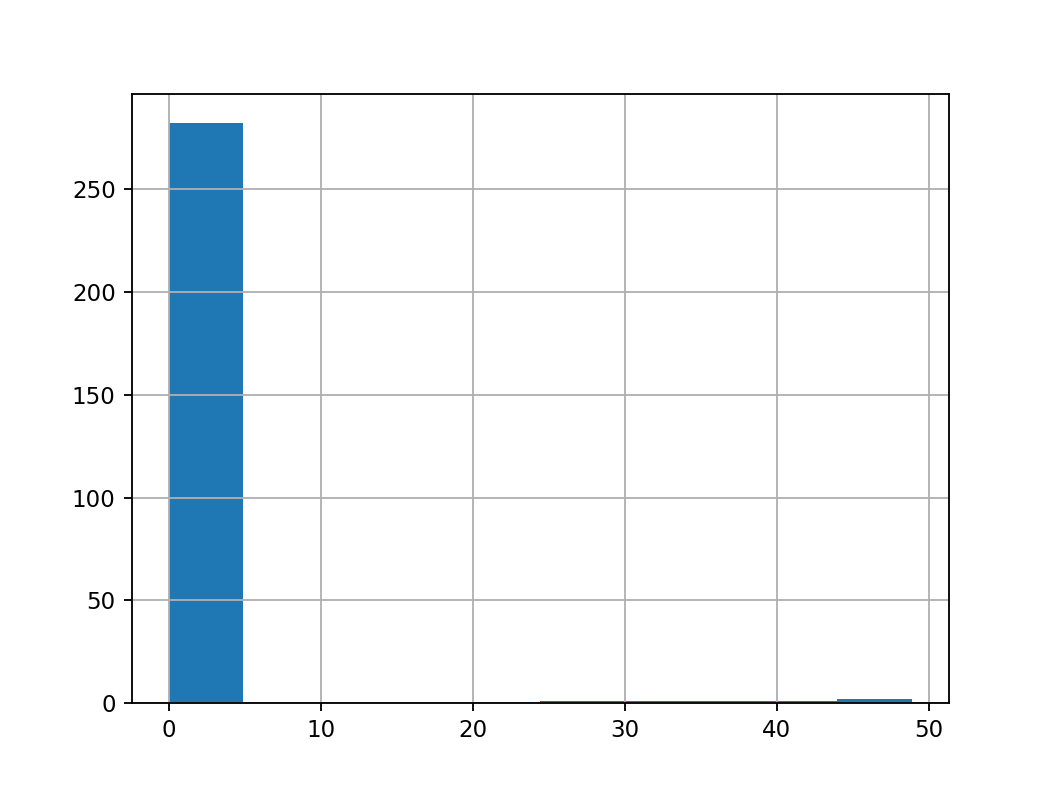

<AxesSubplot:>

In [90]:
plt.subplots()
df[df.regime=="1"][df[df.regime=="1"].param1_f_ratio<0.1][  np.hstack([ [f"param{i}_i_ratio",f"param{i}_f_ratio"] for i in range(4) ])].param3_i_ratio.hist()

In [94]:
regimes_table = np.array([
    [1, 10, 2*10**3, 2*10**3, 10**5], #0
    [1, 2, 2*10**3, 2*10**3, 2*10**4], #1
    [1, 1, 2*10**3, 2*10**3, 10**4], #2
    [1, 10, 50, 50, 10**5], #3
    [1, 10, 50, 100, 10**5], #4
    [1, 10, 100, 50, 10**5], #5
    [1, 1, 5, 5, 10**4], #6
    [1, 1, 5, 10, 10**4], #7
    [1, 1, 10, 5, 10**4], #8
])

<IPython.core.display.Javascript object>


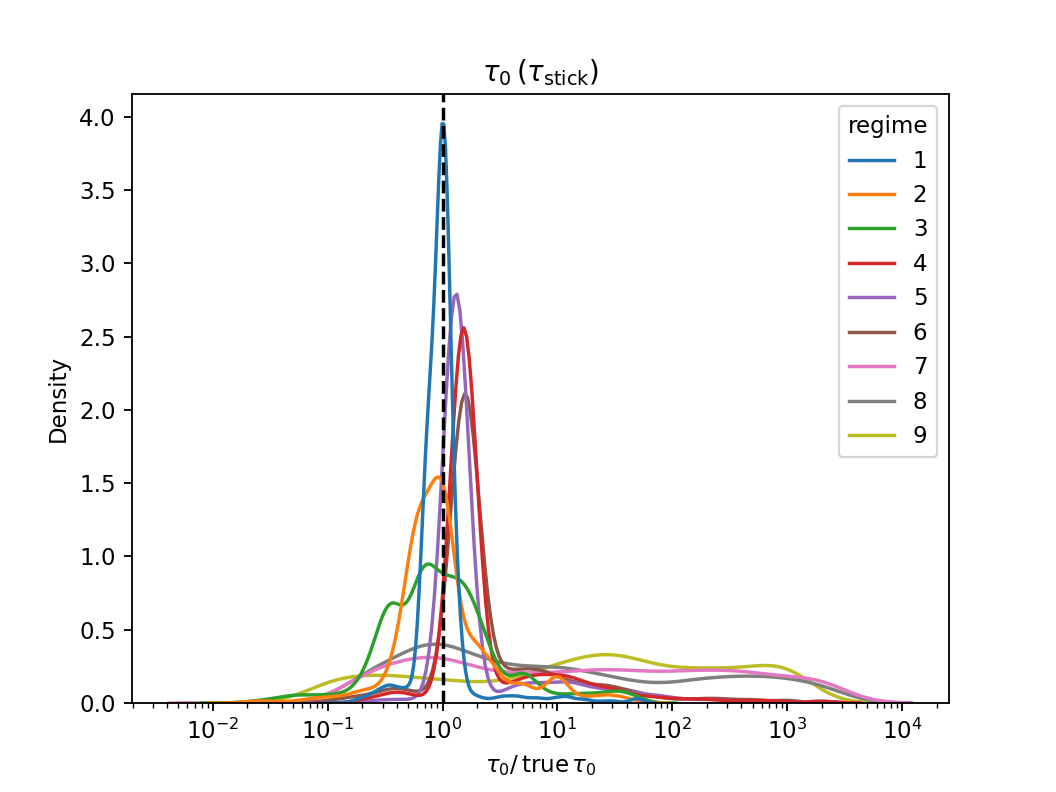

In [58]:
fig,ax=plt.subplots()
sns.kdeplot(data=df,x="param0_f_ratio",hue="regime",common_norm=False,clip=[-10,np.inf],log_scale=True)
ylim = ax.get_ylim()
ax.plot([1,1],[0,ylim[1]],linestyle="--",color="k")
ax.set_ylim(ylim)
_=ax.set_title(r'$\tau _0\,(\tau_{\rm stick})$')
_=ax.set_xlabel(r'$\tau _0 /\, {\rm true}\, \tau_0$')

<IPython.core.display.Javascript object>


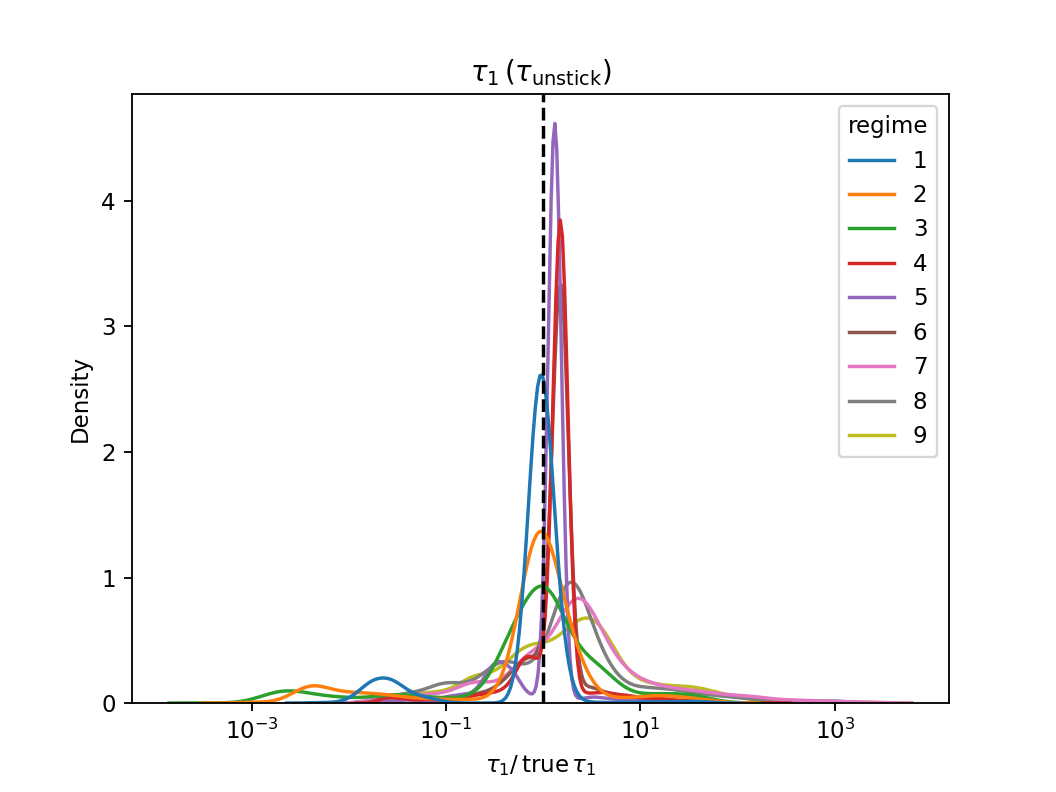

In [61]:
fig,ax=plt.subplots()
sns.kdeplot(data=df,x="param1_f_ratio",hue="regime",common_norm=False,clip=[-10,np.inf],log_scale=True)
ylim = ax.get_ylim()
ax.plot([1,1],[0,ylim[1]],linestyle="--",color="k")
ax.set_ylim(ylim)
_=ax.set_title(r'$\tau _1\,(\tau_{\rm unstick})$')
_=ax.set_xlabel(r'$\tau _1 /\, {\rm true}\, \tau_1$')

<IPython.core.display.Javascript object>


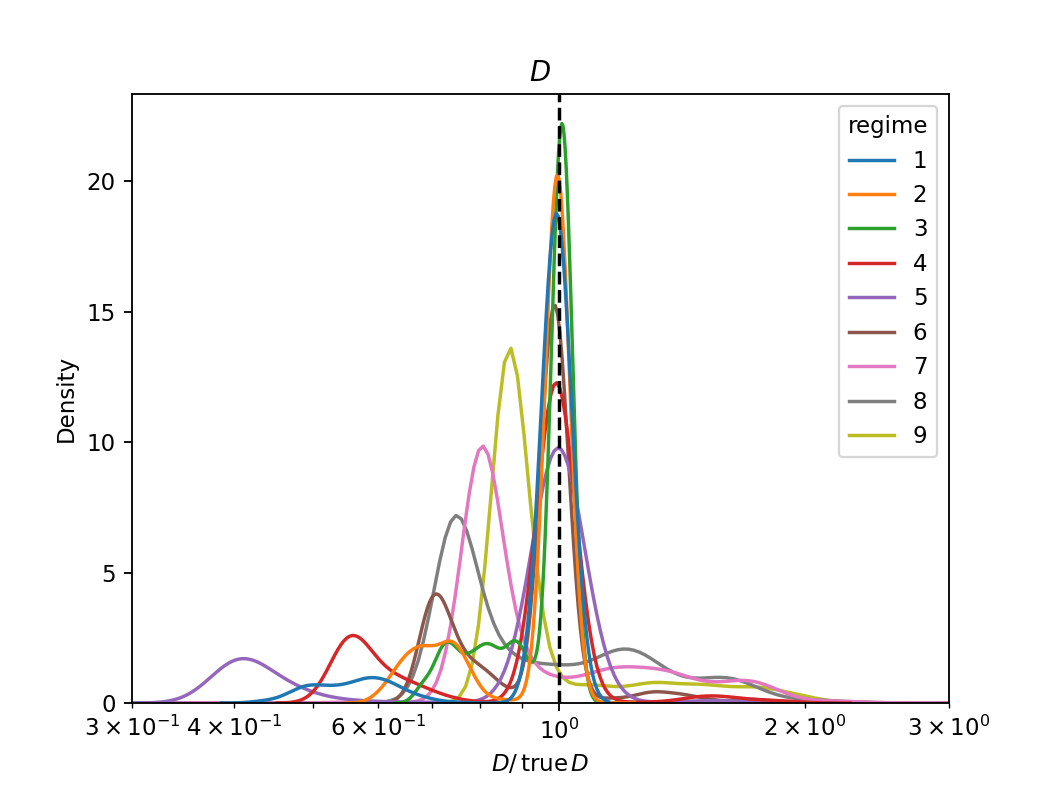

In [71]:
fig,ax=plt.subplots()
sns.kdeplot(data=df,x="param2_f_ratio",hue="regime",common_norm=False,clip=[-10,np.inf],log_scale=True)
ylim = ax.get_ylim()
ax.plot([1,1],[0,ylim[1]],linestyle="--",color="k")
ax.set_ylim(ylim)
_=ax.set_title(r'$D$')
_=ax.set_xlabel(r'$D /\, {\rm true}\, D$')

<IPython.core.display.Javascript object>


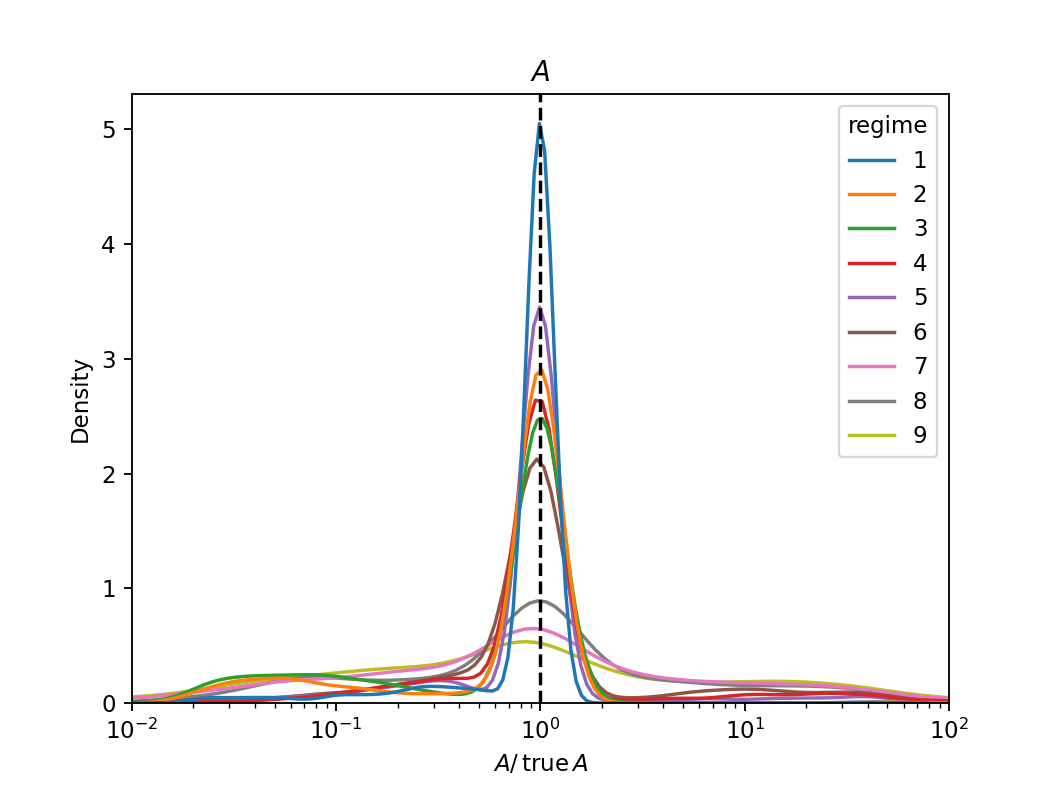

In [75]:
fig,ax=plt.subplots()
sns.kdeplot(data=df,x="param3_f_ratio",hue="regime",common_norm=False,clip=[-10,np.inf],log_scale=True)
ylim = ax.get_ylim()
ax.plot([1,1],[0,ylim[1]],linestyle="--",color="k")
ax.set_ylim(ylim)
_=ax.set_title(r'$A$')
_=ax.set_xlabel(r'$A /\, {\rm true}\, A$')